## Model Comparison: Bootstrap Difference Confidence Intervals

This notebook compares model performance using bootstrap confidence intervals on the **difference** in AUC metrics.

### Why Bootstrap the Difference?

- AUC(Model A) and AUC(Model B) are **paired** (same test set)
- Significance depends on the distribution of **AUC(A) - AUC(B)**
- Overlapping individual CIs don't tell us about significance
- This method directly answers: **Is Model A statistically better than Model B?**

### Interpretation:

- **CI entirely > 0**: Model A significantly better (p < 0.05)
- **CI entirely < 0**: Model B significantly better
- **CI includes 0**: No significant difference

### 1. Imports and Setup

In [3]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass
sns.set_palette("husl")

print("✓ All packages loaded successfully")


✓ All packages loaded successfully


### 2. Bootstrap Difference CI Function


In [ ]:
def bootstrap_difference_ci(y_true, y_pred_proba_model1, y_pred_proba_model2, 
                           metric_func, n_bootstrap=1000, confidence=0.95, 
                           random_state=42):

    # Convert to numpy arrays
    y_true = np.asarray(y_true)
    y_pred_proba_model1 = np.asarray(y_pred_proba_model1)
    y_pred_proba_model2 = np.asarray(y_pred_proba_model2)
    
    np.random.seed(random_state)
    
    # Calculate original difference
    auc1 = metric_func(y_true, y_pred_proba_model1)
    auc2 = metric_func(y_true, y_pred_proba_model2)
    diff_value = auc1 - auc2
    
    # Bootstrap the difference
    bootstrap_diffs = []
    n_samples = len(y_true)
    
    rng = np.random.RandomState(random_state)
    for i in range(n_bootstrap):
        indices = rng.choice(n_samples, size=n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred1_boot = y_pred_proba_model1[indices]
        y_pred2_boot = y_pred_proba_model2[indices]
        
        try:
            auc1_boot = metric_func(y_true_boot, y_pred1_boot)
            auc2_boot = metric_func(y_true_boot, y_pred2_boot)
            diff_boot = auc1_boot - auc2_boot
            bootstrap_diffs.append(diff_boot)
        except ValueError:
            continue
    
    # Calculate CI
    alpha = 1 - confidence
    ci_lower = np.percentile(bootstrap_diffs, 100 * alpha / 2)
    ci_upper = np.percentile(bootstrap_diffs, 100 * (1 - alpha / 2))
    
    # Check if significant 
    is_significant = (ci_lower > 0) or (ci_upper < 0)
    
    return diff_value, ci_lower, ci_upper, is_significant


### 3. Load Model Predictions


In [ ]:
# Load all model predictions
predictions_dir = Path(".")

print("Loading model predictions...")

# Load Logistic Regression
with open(predictions_dir / "logistic_regression_test_proba.pkl", "rb") as f:
    lr_data = pickle.load(f)
    print(f"✓ Loaded {lr_data['model_name']}")

# Load Random Forest
with open(predictions_dir / "random_forest_test_proba.pkl", "rb") as f:
    rf_data = pickle.load(f)
    print(f"✓ Loaded {rf_data['model_name']}")

# Load XGBoost
with open(predictions_dir / "xgboost_test_proba.pkl", "rb") as f:
    xgb_data = pickle.load(f)
    print(f"✓ Loaded {xgb_data['model_name']}")

# Load MLP
with open(predictions_dir / "mlp_test_proba.pkl", "rb") as f:
    mlp_data = pickle.load(f)
    print(f"✓ Loaded {mlp_data['model_name']}")

# Verify all models used the same test set
y_test_lr = np.asarray(lr_data['y_test'])
y_test_rf = np.asarray(rf_data['y_test'])
y_test_xgb = np.asarray(xgb_data['y_test'])
y_test_mlp = np.asarray(mlp_data['y_test'])

if (np.array_equal(y_test_lr, y_test_rf) and 
    np.array_equal(y_test_lr, y_test_xgb) and 
    np.array_equal(y_test_lr, y_test_mlp)):
    print("\n✓ All models used the same test set - comparison is valid!")
    y_test = y_test_lr
else:
    print("\n⚠ WARNING: Models used different test sets!")
    print(f"  LR test set size: {len(y_test_lr)}")
    print(f"  RF test set size: {len(y_test_rf)}")
    print(f"  XGB test set size: {len(y_test_xgb)}")
    print(f"  MLP test set size: {len(y_test_mlp)}")
    y_test = y_test_lr  

print(f"\nTest set size: {len(y_test)}")
print(f"Positive class proportion: {y_test.mean():.4f}")


Loading model predictions...
✓ Loaded LogisticRegression
✓ Loaded RandomForest
✓ Loaded XGBoost

✓ All models used the same test set - comparison is valid!

Test set size: 4003
Positive class proportion: 0.2863


### 4. Calculate Individual Model Metrics


In [6]:
# Calculate individual metrics for reference
lr_roc = roc_auc_score(y_test, lr_data['test_proba'])
lr_pr = average_precision_score(y_test, lr_data['test_proba'])

rf_roc = roc_auc_score(y_test, rf_data['test_proba'])
rf_pr = average_precision_score(y_test, rf_data['test_proba'])

xgb_roc = roc_auc_score(y_test, xgb_data['test_proba'])
xgb_pr = average_precision_score(y_test, xgb_data['test_proba'])

mlp_roc = roc_auc_score(y_test, mlp_data['test_proba'])
mlp_pr = average_precision_score(y_test, mlp_data['test_proba'])

print("="*70)
print("INDIVIDUAL MODEL PERFORMANCE (for reference)")
print("="*70)
print(f"\n{'Model':<20} {'ROC AUC':<15} {'PR AUC':<15}")
print("-"*70)
print(f"{'Logistic Regression':<20} {lr_roc:<15.4f} {lr_pr:<15.4f}")
print(f"{'Random Forest':<20} {rf_roc:<15.4f} {rf_pr:<15.4f}")
print(f"{'XGBoost':<20} {xgb_roc:<15.4f} {xgb_pr:<15.4f}")
print(f"{'MLP':<20} {mlp_roc:<15.4f} {mlp_pr:<15.4f}")
print("="*70)


INDIVIDUAL MODEL PERFORMANCE (for reference)

Model                ROC AUC         PR AUC         
----------------------------------------------------------------------
Logistic Regression  0.9414          0.8135         
Random Forest        0.9571          0.8706         
XGBoost              0.9589          0.8814         


### 5. Bootstrap Difference CIs: ROC AUC


In [7]:
print("\n" + "="*70)
print("BOOTSTRAP DIFFERENCE CONFIDENCE INTERVALS: ROC AUC")
print("="*70)
print("\nCalculating bootstrap CIs (this may take a moment)...")

# XGBoost vs Random Forest
xgb_rf_roc_diff, xgb_rf_roc_lower, xgb_rf_roc_upper, xgb_rf_roc_sig = bootstrap_difference_ci(
    y_test, xgb_data['test_proba'], rf_data['test_proba'], roc_auc_score, n_bootstrap=1000
)

# XGBoost vs Logistic Regression
xgb_lr_roc_diff, xgb_lr_roc_lower, xgb_lr_roc_upper, xgb_lr_roc_sig = bootstrap_difference_ci(
    y_test, xgb_data['test_proba'], lr_data['test_proba'], roc_auc_score, n_bootstrap=1000
)

# Random Forest vs Logistic Regression
rf_lr_roc_diff, rf_lr_roc_lower, rf_lr_roc_upper, rf_lr_roc_sig = bootstrap_difference_ci(
    y_test, rf_data['test_proba'], lr_data['test_proba'], roc_auc_score, n_bootstrap=1000
)

# XGBoost vs MLP
xgb_mlp_roc_diff, xgb_mlp_roc_lower, xgb_mlp_roc_upper, xgb_mlp_roc_sig = bootstrap_difference_ci(
    y_test, xgb_data['test_proba'], mlp_data['test_proba'], roc_auc_score, n_bootstrap=1000
)

# Random Forest vs MLP
rf_mlp_roc_diff, rf_mlp_roc_lower, rf_mlp_roc_upper, rf_mlp_roc_sig = bootstrap_difference_ci(
    y_test, rf_data['test_proba'], mlp_data['test_proba'], roc_auc_score, n_bootstrap=1000
)

# Logistic Regression vs MLP
lr_mlp_roc_diff, lr_mlp_roc_lower, lr_mlp_roc_upper, lr_mlp_roc_sig = bootstrap_difference_ci(
    y_test, lr_data['test_proba'], mlp_data['test_proba'], roc_auc_score, n_bootstrap=1000
)

# Display results
results_roc = [
    {"Comparison": "XGBoost - Random Forest", 
     "Difference": xgb_rf_roc_diff, 
     "CI Lower": xgb_rf_roc_lower, 
     "CI Upper": xgb_rf_roc_upper, 
     "Significant": xgb_rf_roc_sig},
    {"Comparison": "XGBoost - Logistic Regression", 
     "Difference": xgb_lr_roc_diff, 
     "CI Lower": xgb_lr_roc_lower, 
     "CI Upper": xgb_lr_roc_upper, 
     "Significant": xgb_lr_roc_sig},
    {"Comparison": "XGBoost - MLP", 
     "Difference": xgb_mlp_roc_diff, 
     "CI Lower": xgb_mlp_roc_lower, 
     "CI Upper": xgb_mlp_roc_upper, 
     "Significant": xgb_mlp_roc_sig},
    {"Comparison": "Random Forest - Logistic Regression", 
     "Difference": rf_lr_roc_diff, 
     "CI Lower": rf_lr_roc_lower, 
     "CI Upper": rf_lr_roc_upper, 
     "Significant": rf_lr_roc_sig},
    {"Comparison": "Random Forest - MLP", 
     "Difference": rf_mlp_roc_diff, 
     "CI Lower": rf_mlp_roc_lower, 
     "CI Upper": rf_mlp_roc_upper, 
     "Significant": rf_mlp_roc_sig},
    {"Comparison": "Logistic Regression - MLP", 
     "Difference": lr_mlp_roc_diff, 
     "CI Lower": lr_mlp_roc_lower, 
     "CI Upper": lr_mlp_roc_upper, 
     "Significant": lr_mlp_roc_sig}
]

df_roc = pd.DataFrame(results_roc)
df_roc['Interpretation'] = df_roc.apply(
    lambda row: '✓ Significantly better' if (row['CI Lower'] > 0) 
    else ('✓ Significantly worse' if row['CI Upper'] < 0 else '✗ No significant difference'), 
    axis=1
)

print("\n" + "-"*70)
print(f"{'Comparison':<35} {'Difference':<12} {'95% CI':<25} {'Result'}")
print("-"*70)
for _, row in df_roc.iterrows():
    print(f"{row['Comparison']:<35} {row['Difference']:>10.4f}   [{row['CI Lower']:>6.4f}, {row['CI Upper']:>6.4f}]   {row['Interpretation']}")
print("-"*70)



BOOTSTRAP DIFFERENCE CONFIDENCE INTERVALS: ROC AUC

Calculating bootstrap CIs (this may take a moment)...

----------------------------------------------------------------------
Comparison                          Difference   95% CI                    Result
----------------------------------------------------------------------
XGBoost - Random Forest                 0.0018   [-0.0003, 0.0039]   ✗ No significant difference
XGBoost - Logistic Regression           0.0175   [0.0132, 0.0218]   ✓ Significantly better
Random Forest - Logistic Regression     0.0157   [0.0114, 0.0201]   ✓ Significantly better
----------------------------------------------------------------------


### 6. Bootstrap Difference CIs: PR AUC


In [8]:
print("\n" + "="*70)
print("BOOTSTRAP DIFFERENCE CONFIDENCE INTERVALS: PR AUC")
print("="*70)
print("\nCalculating bootstrap CIs (this may take a moment)...")

# XGBoost vs Random Forest
xgb_rf_pr_diff, xgb_rf_pr_lower, xgb_rf_pr_upper, xgb_rf_pr_sig = bootstrap_difference_ci(
    y_test, xgb_data['test_proba'], rf_data['test_proba'], average_precision_score, n_bootstrap=1000
)

# XGBoost vs Logistic Regression
xgb_lr_pr_diff, xgb_lr_pr_lower, xgb_lr_pr_upper, xgb_lr_pr_sig = bootstrap_difference_ci(
    y_test, xgb_data['test_proba'], lr_data['test_proba'], average_precision_score, n_bootstrap=1000
)

# Random Forest vs Logistic Regression
rf_lr_pr_diff, rf_lr_pr_lower, rf_lr_pr_upper, rf_lr_pr_sig = bootstrap_difference_ci(
    y_test, rf_data['test_proba'], lr_data['test_proba'], average_precision_score, n_bootstrap=1000
)

# XGBoost vs MLP
xgb_mlp_pr_diff, xgb_mlp_pr_lower, xgb_mlp_pr_upper, xgb_mlp_pr_sig = bootstrap_difference_ci(
    y_test, xgb_data['test_proba'], mlp_data['test_proba'], average_precision_score, n_bootstrap=1000
)

# Random Forest vs MLP
rf_mlp_pr_diff, rf_mlp_pr_lower, rf_mlp_pr_upper, rf_mlp_pr_sig = bootstrap_difference_ci(
    y_test, rf_data['test_proba'], mlp_data['test_proba'], average_precision_score, n_bootstrap=1000
)

# Logistic Regression vs MLP
lr_mlp_pr_diff, lr_mlp_pr_lower, lr_mlp_pr_upper, lr_mlp_pr_sig = bootstrap_difference_ci(
    y_test, lr_data['test_proba'], mlp_data['test_proba'], average_precision_score, n_bootstrap=1000
)

# Display results
results_pr = [
    {"Comparison": "XGBoost - Random Forest", 
     "Difference": xgb_rf_pr_diff, 
     "CI Lower": xgb_rf_pr_lower, 
     "CI Upper": xgb_rf_pr_upper, 
     "Significant": xgb_rf_pr_sig},
    {"Comparison": "XGBoost - Logistic Regression", 
     "Difference": xgb_lr_pr_diff, 
     "CI Lower": xgb_lr_pr_lower, 
     "CI Upper": xgb_lr_pr_upper, 
     "Significant": xgb_lr_pr_sig},
    {"Comparison": "XGBoost - MLP", 
     "Difference": xgb_mlp_pr_diff, 
     "CI Lower": xgb_mlp_pr_lower, 
     "CI Upper": xgb_mlp_pr_upper, 
     "Significant": xgb_mlp_pr_sig},
    {"Comparison": "Random Forest - Logistic Regression", 
     "Difference": rf_lr_pr_diff, 
     "CI Lower": rf_lr_pr_lower, 
     "CI Upper": rf_lr_pr_upper, 
     "Significant": rf_lr_pr_sig},
    {"Comparison": "Random Forest - MLP", 
     "Difference": rf_mlp_pr_diff, 
     "CI Lower": rf_mlp_pr_lower, 
     "CI Upper": rf_mlp_pr_upper, 
     "Significant": rf_mlp_pr_sig},
    {"Comparison": "Logistic Regression - MLP", 
     "Difference": lr_mlp_pr_diff, 
     "CI Lower": lr_mlp_pr_lower, 
     "CI Upper": lr_mlp_pr_upper, 
     "Significant": lr_mlp_pr_sig}
]

df_pr = pd.DataFrame(results_pr)
df_pr['Interpretation'] = df_pr.apply(
    lambda row: '✓ Significantly better' if (row['CI Lower'] > 0) 
    else ('✓ Significantly worse' if row['CI Upper'] < 0 else '✗ No significant difference'), 
    axis=1
)

print("\n" + "-"*70)
print(f"{'Comparison':<35} {'Difference':<12} {'95% CI':<25} {'Result'}")
print("-"*70)
for _, row in df_pr.iterrows():
    print(f"{row['Comparison']:<35} {row['Difference']:>10.4f}   [{row['CI Lower']:>6.4f}, {row['CI Upper']:>6.4f}]   {row['Interpretation']}")
print("-"*70)



BOOTSTRAP DIFFERENCE CONFIDENCE INTERVALS: PR AUC

Calculating bootstrap CIs (this may take a moment)...

----------------------------------------------------------------------
Comparison                          Difference   95% CI                    Result
----------------------------------------------------------------------
XGBoost - Random Forest                 0.0109   [0.0032, 0.0183]   ✓ Significantly better
XGBoost - Logistic Regression           0.0679   [0.0506, 0.0869]   ✓ Significantly better
Random Forest - Logistic Regression     0.0571   [0.0382, 0.0765]   ✓ Significantly better
----------------------------------------------------------------------


### 7. Visualization: Difference CIs


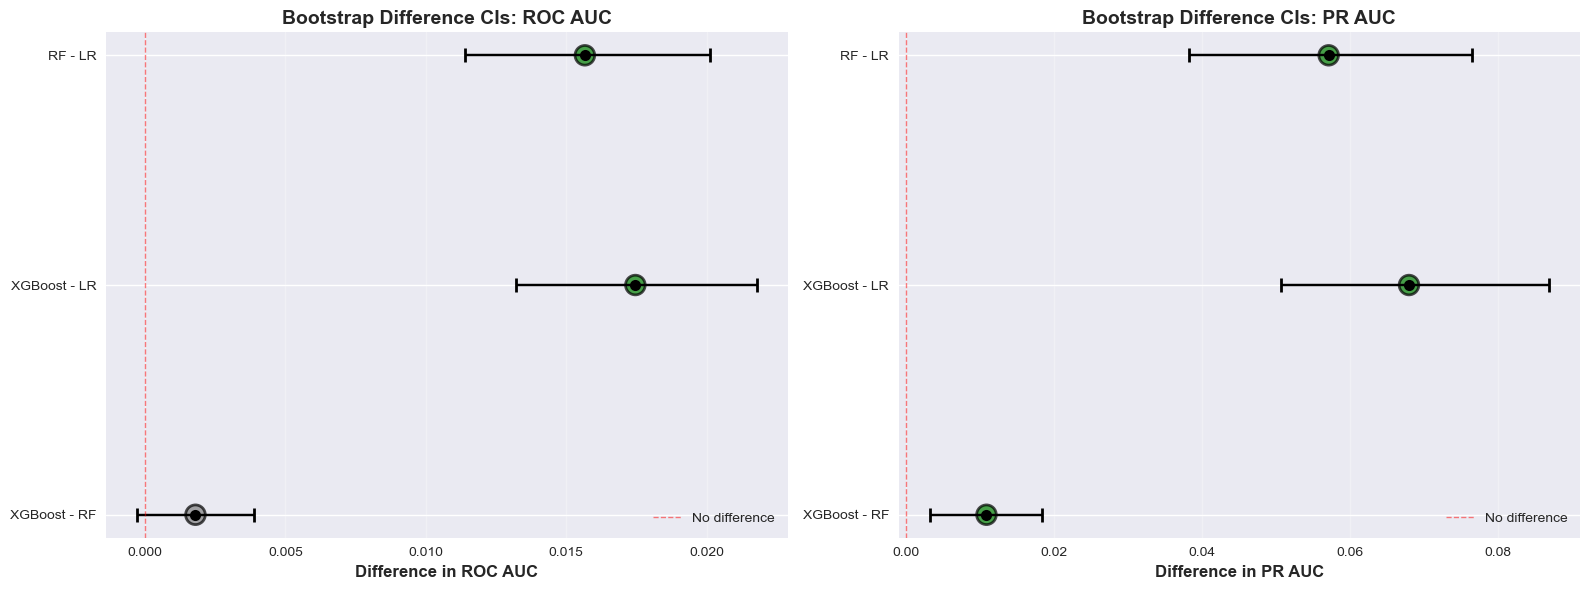


Legend:
  Green = First model significantly better
  Red = First model significantly worse
  Gray = No significant difference


In [9]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ROC AUC Differences
ax1 = axes[0]
comparisons = ['XGBoost - RF', 'XGBoost - LR', 'XGBoost - MLP', 'RF - LR', 'RF - MLP', 'LR - MLP']
diffs_roc = [xgb_rf_roc_diff, xgb_lr_roc_diff, xgb_mlp_roc_diff, rf_lr_roc_diff, rf_mlp_roc_diff, lr_mlp_roc_diff]
ci_lowers_roc = [xgb_rf_roc_lower, xgb_lr_roc_lower, xgb_mlp_roc_lower, rf_lr_roc_lower, rf_mlp_roc_lower, lr_mlp_roc_lower]
ci_uppers_roc = [xgb_rf_roc_upper, xgb_lr_roc_upper, xgb_mlp_roc_upper, rf_lr_roc_upper, rf_mlp_roc_upper, lr_mlp_roc_upper]

colors = ['green' if lower > 0 else ('red' if upper < 0 else 'gray') 
          for lower, upper in zip(ci_lowers_roc, ci_uppers_roc)]

y_pos = np.arange(len(comparisons))
ax1.errorbar(diffs_roc, y_pos, xerr=[np.array(diffs_roc) - np.array(ci_lowers_roc), 
                                      np.array(ci_uppers_roc) - np.array(diffs_roc)], 
             fmt='o', capsize=5, capthick=2, markersize=8, color='black')
ax1.scatter(diffs_roc, y_pos, s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No difference')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(comparisons)
ax1.set_xlabel('Difference in ROC AUC', fontsize=12, fontweight='bold')
ax1.set_title('Bootstrap Difference CIs: ROC AUC', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.legend()

# PR AUC Differences
ax2 = axes[1]
diffs_pr = [xgb_rf_pr_diff, xgb_lr_pr_diff, xgb_mlp_pr_diff, rf_lr_pr_diff, rf_mlp_pr_diff, lr_mlp_pr_diff]
ci_lowers_pr = [xgb_rf_pr_lower, xgb_lr_pr_lower, xgb_mlp_pr_lower, rf_lr_pr_lower, rf_mlp_pr_lower, lr_mlp_pr_lower]
ci_uppers_pr = [xgb_rf_pr_upper, xgb_lr_pr_upper, xgb_mlp_pr_upper, rf_lr_pr_upper, rf_mlp_pr_upper, lr_mlp_pr_upper]

colors = ['green' if lower > 0 else ('red' if upper < 0 else 'gray') 
          for lower, upper in zip(ci_lowers_pr, ci_uppers_pr)]

ax2.errorbar(diffs_pr, y_pos, xerr=[np.array(diffs_pr) - np.array(ci_lowers_pr), 
                                    np.array(ci_uppers_pr) - np.array(diffs_pr)], 
             fmt='o', capsize=5, capthick=2, markersize=8, color='black')
ax2.scatter(diffs_pr, y_pos, s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No difference')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(comparisons)
ax2.set_xlabel('Difference in PR AUC', fontsize=12, fontweight='bold')
ax2.set_title('Bootstrap Difference CIs: PR AUC', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.legend()

plt.tight_layout()
plt.show()

print("\nLegend:")
print("  Green = First model significantly better")
print("  Red = First model significantly worse")
print("  Gray = No significant difference")


### 8. Summary Table


In [ ]:
# Create summary table
summary_data = {
    'Metric': ['ROC AUC', 'ROC AUC', 'ROC AUC', 'ROC AUC', 'ROC AUC', 'ROC AUC', 'PR AUC', 'PR AUC', 'PR AUC', 'PR AUC', 'PR AUC', 'PR AUC'],
    'Comparison': ['XGBoost - Random Forest', 'XGBoost - Logistic Regression', 'XGBoost - MLP',
                   'Random Forest - Logistic Regression', 'Random Forest - MLP', 'Logistic Regression - MLP',
                   'XGBoost - Random Forest', 'XGBoost - Logistic Regression', 'XGBoost - MLP',
                   'Random Forest - Logistic Regression', 'Random Forest - MLP', 'Logistic Regression - MLP'],
    'Difference': [xgb_rf_roc_diff, xgb_lr_roc_diff, xgb_mlp_roc_diff, rf_lr_roc_diff, rf_mlp_roc_diff, lr_mlp_roc_diff,
                  xgb_rf_pr_diff, xgb_lr_pr_diff, xgb_mlp_pr_diff, rf_lr_pr_diff, rf_mlp_pr_diff, lr_mlp_pr_diff],
    'CI Lower': [xgb_rf_roc_lower, xgb_lr_roc_lower, xgb_mlp_roc_lower, rf_lr_roc_lower, rf_mlp_roc_lower, lr_mlp_roc_lower,
                xgb_rf_pr_lower, xgb_lr_pr_lower, xgb_mlp_pr_lower, rf_lr_pr_lower, rf_mlp_pr_lower, lr_mlp_pr_lower],
    'CI Upper': [xgb_rf_roc_upper, xgb_lr_roc_upper, xgb_mlp_roc_upper, rf_lr_roc_upper, rf_mlp_roc_upper, lr_mlp_roc_upper,
                xgb_rf_pr_upper, xgb_lr_pr_upper, xgb_mlp_pr_upper, rf_lr_pr_upper, rf_mlp_pr_upper, lr_mlp_pr_upper],
    'Significant': [xgb_rf_roc_sig, xgb_lr_roc_sig, xgb_mlp_roc_sig, rf_lr_roc_sig, rf_mlp_roc_sig, lr_mlp_roc_sig,
                    xgb_rf_pr_sig, xgb_lr_pr_sig, xgb_mlp_pr_sig, rf_lr_pr_sig, rf_mlp_pr_sig, lr_mlp_pr_sig]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Interpretation'] = summary_df.apply(
    lambda row: 'First model better' if (row['CI Lower'] > 0) 
    else ('Second model better' if row['CI Upper'] < 0 else 'No significant difference'), 
    axis=1
)

print("\n" + "="*90)
print("COMPREHENSIVE SUMMARY: BOOTSTRAP DIFFERENCE CONFIDENCE INTERVALS")
print("="*90)
print(summary_df.to_string(index=False))
print("="*90)

# Save summary to CSV
summary_df.to_csv('model_comparison_bootstrap_differences.csv', index=False)
print("\n✓ Summary saved to: model_comparison_bootstrap_differences.csv")



COMPREHENSIVE SUMMARY: BOOTSTRAP DIFFERENCE CONFIDENCE INTERVALS
 Metric                          Comparison  Difference  CI Lower  CI Upper  Significant            Interpretation
ROC AUC             XGBoost - Random Forest    0.001798 -0.000282  0.003880        False No significant difference
ROC AUC       XGBoost - Logistic Regression    0.017465  0.013217  0.021781         True        First model better
ROC AUC Random Forest - Logistic Regression    0.015668  0.011401  0.020108         True        First model better
 PR AUC             XGBoost - Random Forest    0.010854  0.003168  0.018316         True        First model better
 PR AUC       XGBoost - Logistic Regression    0.067940  0.050646  0.086860         True        First model better
 PR AUC Random Forest - Logistic Regression    0.057086  0.038164  0.076483         True        First model better

✓ Summary saved to: model_comparison_bootstrap_differences.csv


### 9. Key Findings

Based on the bootstrap difference confidence intervals:

1. **If CI entirely > 0**: The first model is significantly better (p < 0.05)
2. **If CI entirely < 0**: The second model is significantly better
3. **If CI includes 0**: No statistically significant difference

This method accounts for the paired nature of the predictions (same test set) and provides a more rigorous comparison than simply comparing overlapping individual CIs.
